In [11]:
import warnings

import numpy as np

from scipy.stats import entropy
from scipy.special import rel_entr, kl_div, entr

# Computing information gain and its components 
### John R. Lawson, October 2022

This shows the code and mathematics of evaluating a time series of paired forecast/observation probabilities.
The assumption is for two observation categories: 0 and 1. 
The code can be developed further for >2 classes, continuous ranked (like CRPS), and observational uncertainty (Cross-Entropy Score).

If evaluating event-by-event (like Lawson et al 2021 for cell-by-cell), don't decompose it

In [12]:
import numpy as np

def generate_time_series(seed=42,num_samples=10000):
    # np.random.seed(seed)
    rng = np.random.default_rng(seed=seed)

    
    # Generate the 'o' time series with ~5% frequency of '1'
    # o = np.random.choice([0, 1], size=num_samples, p=[0.9, 0.1])
    o = rng.choice([0, 1], size=num_samples, p=[0.8, 0.2])
    
    # Initialize 'f' as an empty array
    f = np.zeros(num_samples)
    
    for i in range(num_samples):
        if o[i] == 1:
            # Generate a high probability value between 0.50 and 0.99

            f[i] = rng.choice(np.arange(0.90, 0.995, 0.01))
            # f[i] = np.random.choice(np.arange(0.70, 1.00, 0.01))
        else:
            # Generate a low probability value between 0.01 and 0.49
            # f[i] = np.random.choice(np.arange(0.01, 0.20, 0.01))
            f[i] = rng.choice(np.arange(0.01, 0.40, 0.01))
            
    return o, f

o, f = generate_time_series()
# print("o:", o)
# print("f:", f)


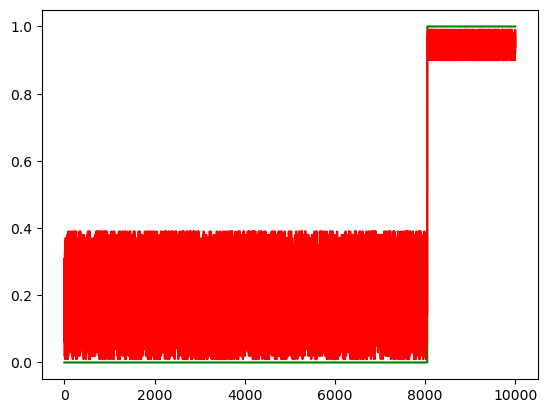

In [13]:
from matplotlib import pyplot as plt
# Observations and forecast probabilities

# o = np.array([1,0,0,0,1,0])
# f = np.array([0.9,0.1,0.3,0.4,0.6,0.6])

# o = np.array([1,0,0,1,0,0,1,0,0])
# f = np.array([0.6,0.4,0.1,0.99,0.1,0.01,0.8,0.5,0.2])

# Use loaded DKL 
# del DKL
from dkl import DKL

# print(o[:50],f[:50])
# print(f.max())

dkl_ = DKL(o,f)

fig,ax = plt.subplots(1)
ind = np.argsort(o)
o = o[ind]
f = f[ind]
ax.plot(o,color="green")
ax.plot(f,color="red")

### Uncertainty component
This is only defined for >2 values. The frequency of one event occurring gives certainty (entropy = 0)
Uncertainty is otherwise the prior entropy (1 bit for coin)
-log2(prob)

In [14]:
print(dkl_.compute_unc())
# print(dkl.compute_unc_TA2010())

0.712632141210245


### Reliability component
The information lost via "probabilistic false alarm" or incorrect categorisation of forecast probability
Zero reliability error (information loss) occurs when, e.g., an average 20% risk is issued for an event that occurs 1 in 5 times

In [15]:
print(dkl_.compute_rel())
# print(dkl.compute_rel_TA2010())

0.2896759209584766


### Discrimination component
We might want to return an array of dsc values per probability threshold
dsc_1d shows this currently - can output dkl.k attribute for 1-D array of forecast-probability bins
(Need a visualisation bit later in notebook)

In [16]:
print(dkl_.compute_dsc())
# print(dkl.compute_dsc_TA2010())

0.712632141170183


In [17]:
print(dkl_.compute_dkl(from_components=False))
print(dkl_.compute_dkl(from_components=True))

0.2896759209584766
0.28967592099853856


In [18]:
# print(dkl.compute_dkl_TA2010(from_components=False))
# print(dkl.compute_dkl_TA2010(from_components=True))

In [19]:
bs = dkl_.compute_bs()
bss = dkl_.compute_bss()
print(f"{bs=}, {bss=}")

SS, D_ss, R_ss = dkl_.compute_skill_score(return_components=True)
print(f"{SS=}, {D_ss=}, {R_ss=}")

ig = dkl_.compute_info_gain_over_climo()
print(f"{ig=}")    

bs=0.04368779999999999, bss=0.7221210893045643
SS=0.593512691545754, D_ss=0.9999999999437831, R_ss=0.406487308398029
ig=0.4229562202117064


### Skill scores
You can represent these components normalised by uncertainty
Positive indicates a gain over this measure

We would rather look at information gained over a baseline, but naiveity would be entropy to begin with
Can compare two models (different rho, for instance) and set unc to be dkl, remaining uncertainty in forecast

Information gained between forecasts issued by an old and new model f1 and f2, respectively, is:

In [20]:
np.seterr(divide='ignore')
warnings.filterwarnings('ignore')

class DKL:
    def __init__(self,o,f):
        self.o = o 
        self.f = f
        
        assert np.max(f) < 1.0
        assert np.min(f) > 0.0
        
        # Number of unique forecast probs
        self.k = np.unique(self.f)
        
        # Number of unique classes
        self.c = np.unique(self.o)
        
        # Frequency of obs
        self.o_bar = np.mean(self.o)
            
    @classmethod
    def compute_info_gain(cls,o,f1,f2,from_components=False):
        DKL1 = cls.__compute_dkl(o,f1)
        DKL2 = cls.__compute_dkl(o,f2)
        return DKL1 - DKL2
        
    @staticmethod
    def __compute_dkl(o,f):
        raw_term1 = (1-o)*np.log2((1-o)/(1-f))
        raw_term2 = o*np.log2(o/f)
              
        term1 = np.nan_to_num(raw_term1)
        term2 = np.nan_to_num(raw_term2)
        raw_dkl = term1 + term2 

        # Find nans and convert to 0 
        # Not infinity, as f in {0,1} dealt with already
        # dkl = -term1 -term2
        all_dkl = np.nan_to_num(raw_dkl)
        return all_dkl, np.mean(all_dkl)        
        
    def compute_dkl(self,from_components=False):
        if from_components:
            U = self.compute_unc()
            R = self.compute_rel()
            D = self.compute_dsc()
            return R - D + U
        all_dkl, raw_dkl = self.__compute_dkl(self.o,self.f)
        dkl = np.nan_to_num(raw_dkl)
        # print(f"{all_dkl=}, {raw_dkl=}, {dkl=}")
        return dkl 
    
    def compute_rel(self):
        # N total forecasts
        # K number of unique forecasts 
        # ok_bar is frequency for obs in prob-class k
        # fk is the pmf for prob-class k
        N = len(self.o)
        K = len(self.k)
        rel_1d = np.zeros([K])
        ok_bar_1d = np.zeros([K])
        fk_list = []
        nk_1d = np.zeros([K])
        dkl_1d = np.zeros([K])
        for ik,k in enumerate(self.k):
            ok_bar_1d[ik] = np.mean(self.o[self.f==k])
            fk_list.append(self.f[self.f==k])
            nk_1d[ik] = len(fk_list[ik])
            dkl_k, dkl_all = self.__compute_dkl(ok_bar_1d[ik],fk_list[ik])
            dkl_1d[ik] = np.sum(dkl_all)
            # dkl_1d[ik] = dkl_k
            # print(ok_bar,fk,nk,dkl)
            rel_1d[ik] = (nk_1d[ik]*dkl_1d[ik])
        # rel_1d[rel_1d == np.nan] = 0
        rel_1d = np.nan_to_num(rel_1d)
        # print(f"{rel_1d=}, {ok_bar_1d=}, {fk_list=}, {nk_1d=}, {dkl_1d=}")
        return np.sum(rel_1d)/N
    
    def compute_dsc(self):
        # N total forecasts
        # K number of unique forecasts 
        # ok_bar is frequency for obs in prob-class k
        N = len(self.o)
        K = len(self.k)
        dsc_2d = []
        for ik,k in enumerate(self.k):
            ok_bar = np.mean(self.o[self.f==k])
            fk = self.f[self.f==k]
            nk = len(fk)
            dkl_all, dkl_mean = self.__compute_dkl(ok_bar,self.o_bar)
            # dsc_1d[ik] = nk*dkl_all
            dsc_2d.append(nk*dkl_all)
        # print(f"{dkl_all=}, {dkl_mean=}, {ok_bar=}")      
        dsc_1d = np.nan_to_num(dsc_2d)
        # dsc_1d = 
        return np.sum(dsc_1d)/N
    
    def compute_unc(self):
        term1 = (1-self.o_bar) * np.log2(1-self.o_bar)
        term2 = self.o_bar * np.log2(self.o_bar)
        unc = term1+term2
        # Find nans and convert to 0 
        # Not infinity, as f in {0,1} dealt with already
        return -unc
    
    def compute_bs(self):
        return np.mean((self.o-self.f)**2)
           
        
    